Gradient Boosting Machines (GBMs) with XGBoost

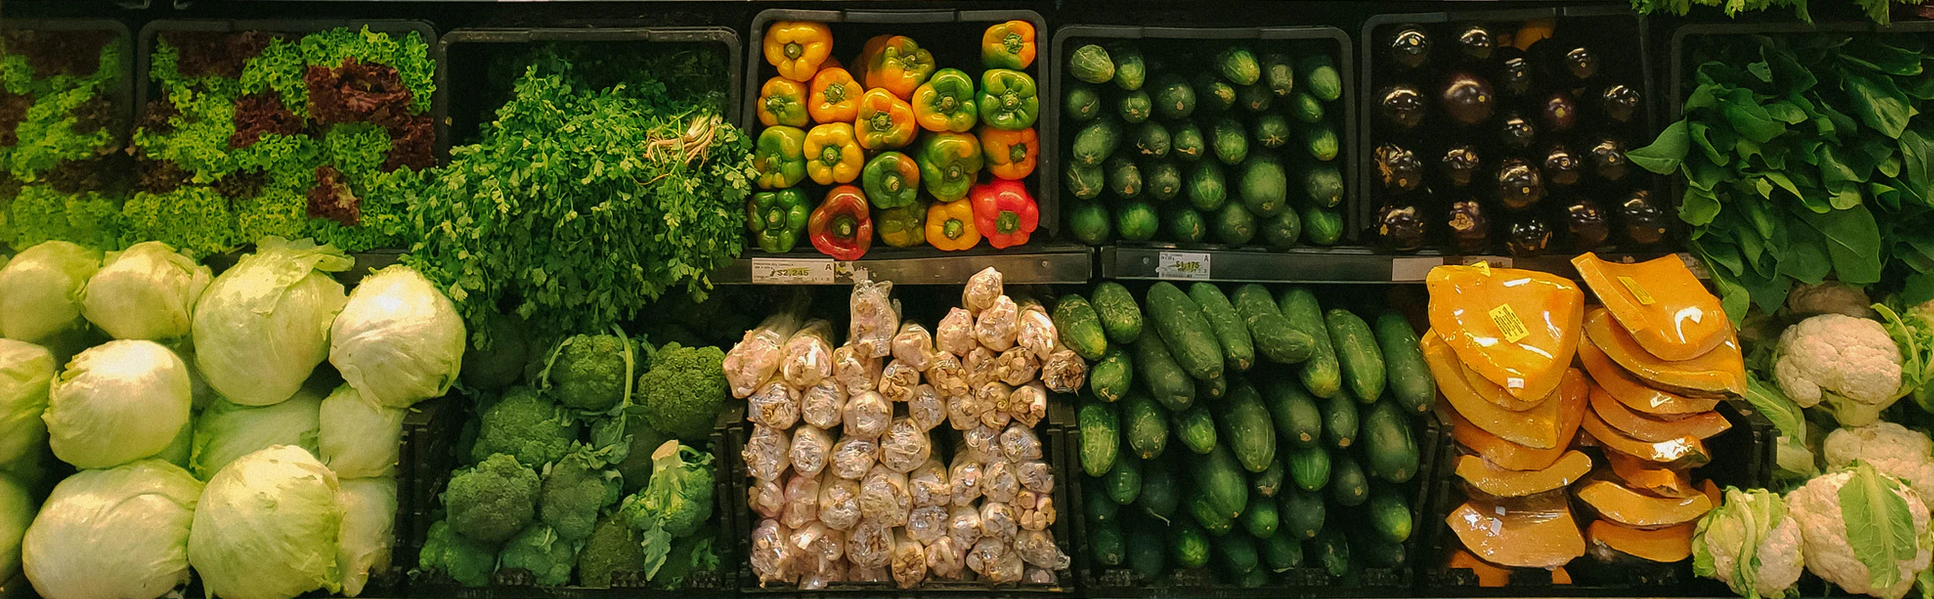

The following topics are covered in this tutorial:

    1. Downloading a real-world dataset from a Kaggle competition
    2. Performing feature engineering and prepare the dataset for training
    3. Training and interpreting a gradient boosting model using XGBoost
    4. Training with KFold cross validation and ensembling results
    5. Configuring the gradient boosting model and tuning hyperparamters

Let's begin by installing the required libraries.   

In [4]:
import pandas as pd

In [5]:
ross_df = pd.read_csv(r'C:\Users\Dell\Downloads\Data Science Stuff\Datasets\Project 4\rossmann-store-sales\train.csv', low_memory=False)
store_df = pd.read_csv(r'C:\Users\Dell\Downloads\Data Science Stuff\Datasets\Project 4\rossmann-store-sales\store.csv')
test_df = pd.read_csv(r'C:\Users\Dell\Downloads\Data Science Stuff\Datasets\Project 4\rossmann-store-sales\test.csv')
submission_df = pd.read_csv(r'C:\Users\Dell\Downloads\Data Science Stuff\Datasets\Project 4\rossmann-store-sales\sample_submission.csv')

In [6]:
ross_df

Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
0            1          5  2015-07-31   5263        555     1      1   
1            2          5  2015-07-31   6064        625     1      1   
2            3          5  2015-07-31   8314        821     1      1   
3            4          5  2015-07-31  13995       1498     1      1   
4            5          5  2015-07-31   4822        559     1      1   
...        ...        ...         ...    ...        ...   ...    ...   
1017204   1111          2  2013-01-01      0          0     0      0   
1017205   1112          2  2013-01-01      0          0     0      0   
1017206   1113          2  2013-01-01      0          0     0      0   
1017207   1114          2  2013-01-01      0          0     0      0   
1017208   1115          2  2013-01-01      0          0     0      0   

        StateHoliday  SchoolHoliday  
0                  0              1  
1                  0              1  
2                  0              1  
3                  0              1  
4                  0              1  
...              ...            ...  
1017204            a              1  
1017205            a              1  
1017206            a              1  
1017207            a              1  
1017208            a              1  

[1017209 rows x 9 columns]

In [7]:
merged_df = ross_df.merge(store_df, how='left', on='Store')
merged_test_df = test_df.merge(store_df, how='left', on='Store')

In [8]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

Date

First, let's convert Date to a datetime column and extract different parts of the date.

In [12]:
def split_date(df): 
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week

In [13]:
split_date(merged_df)
split_date(merged_test_df)

In [14]:
merged_df

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
0            1          5 2015-07-31   5263        555     1      1   
1            2          5 2015-07-31   6064        625     1      1   
2            3          5 2015-07-31   8314        821     1      1   
3            4          5 2015-07-31  13995       1498     1      1   
4            5          5 2015-07-31   4822        559     1      1   
...        ...        ...        ...    ...        ...   ...    ...   
1017204   1111          2 2013-01-01      0          0     0      0   
1017205   1112          2 2013-01-01      0          0     0      0   
1017206   1113          2 2013-01-01      0          0     0      0   
1017207   1114          2 2013-01-01      0          0     0      0   
1017208   1115          2 2013-01-01      0          0     0      0   

        StateHoliday  SchoolHoliday StoreType  ... CompetitionOpenSinceMonth  \
0                  0              1         c  ...                       9.0   
1                  0              1         a  ...                      11.0   
2                  0              1         a  ...                      12.0   
3                  0              1         c  ...                       9.0   
4                  0              1         a  ...                       4.0   
...              ...            ...       ...  ...                       ...   
1017204            a              1         a  ...                       6.0   
1017205            a              1         c  ...                       4.0   
1017206            a              1         a  ...                       NaN   
1017207            a              1         a  ...                       NaN   
1017208            a              1         d  ...                       NaN   

         CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                          2008.0       0              NaN              NaN   
1                          2007.0       1             13.0           2010.0   
2                          2006.0       1             14.0           2011.0   
3                          2009.0       0              NaN              NaN   
4                          2015.0       0              NaN              NaN   
...                           ...     ...              ...              ...   
1017204                    2014.0       1             31.0           2013.0   
1017205                    2006.0       0              NaN              NaN   
1017206                       NaN       0              NaN              NaN   
1017207                       NaN       0              NaN              NaN   
1017208                       NaN       1             22.0           2012.0   

            PromoInterval  Year Month  Day  WeekOfYear  
0                     NaN  2015     7   31          31  
1         Jan,Apr,Jul,Oct  2015     7   31          31  
2         Jan,Apr,Jul,Oct  2015     7   31          31  
3                     NaN  2015     7   31          31  
4                     NaN  2015     7   31          31  
...                   ...   ...   ...  ...         ...  
1017204   Jan,Apr,Jul,Oct  2013     1    1           1  
1017205               NaN  2013     1    1           1  
1017206               NaN  2013     1    1           1  
1017207               NaN  2013     1    1           1  
1017208  Mar,Jun,Sept,Dec  2013     1    1           1  

[1017209 rows x 22 columns]

Store Open/Closed

Next, notice that the sales are zero whenever the store is closed.

In [15]:
merged_df[merged_df.Open == 0].Sales.value_counts()

Sales
0    172817
Name: count, dtype: int64

Instead of trying to model this relationship, it would be better to hard-code it in our predictions, and remove the rows where the store is closed. We won't remove any rows from the test set, since we need to make predictions for every row.

In [16]:
merged_df = merged_df[merged_df.Open == 1].copy()

In [17]:
merged_df

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
0            1          5 2015-07-31   5263        555     1      1   
1            2          5 2015-07-31   6064        625     1      1   
2            3          5 2015-07-31   8314        821     1      1   
3            4          5 2015-07-31  13995       1498     1      1   
4            5          5 2015-07-31   4822        559     1      1   
...        ...        ...        ...    ...        ...   ...    ...   
1016776    682          2 2013-01-01   3375        566     1      0   
1016827    733          2 2013-01-01  10765       2377     1      0   
1016863    769          2 2013-01-01   5035       1248     1      0   
1017042    948          2 2013-01-01   4491       1039     1      0   
1017190   1097          2 2013-01-01   5961       1405     1      0   

        StateHoliday  SchoolHoliday StoreType  ... CompetitionOpenSinceMonth  \
0                  0              1         c  ...                       9.0   
1                  0              1         a  ...                      11.0   
2                  0              1         a  ...                      12.0   
3                  0              1         c  ...                       9.0   
4                  0              1         a  ...                       4.0   
...              ...            ...       ...  ...                       ...   
1016776            a              1         b  ...                       9.0   
1016827            a              1         b  ...                      10.0   
1016863            a              1         b  ...                       NaN   
1017042            a              1         b  ...                       NaN   
1017190            a              1         b  ...                       3.0   

         CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                          2008.0       0              NaN              NaN   
1                          2007.0       1             13.0           2010.0   
2                          2006.0       1             14.0           2011.0   
3                          2009.0       0              NaN              NaN   
4                          2015.0       0              NaN              NaN   
...                           ...     ...              ...              ...   
1016776                    2006.0       0              NaN              NaN   
1016827                    1999.0       0              NaN              NaN   
1016863                       NaN       1             48.0           2012.0   
1017042                       NaN       0              NaN              NaN   
1017190                    2002.0       0              NaN              NaN   

           PromoInterval  Year Month  Day  WeekOfYear  
0                    NaN  2015     7   31          31  
1        Jan,Apr,Jul,Oct  2015     7   31          31  
2        Jan,Apr,Jul,Oct  2015     7   31          31  
3                    NaN  2015     7   31          31  
4                    NaN  2015     7   31          31  
...                  ...   ...   ...  ...         ...  
1016776              NaN  2013     1    1           1  
1016827              NaN  2013     1    1           1  
1016863  Jan,Apr,Jul,Oct  2013     1    1           1  
1017042              NaN  2013     1    1           1  
1017190              NaN  2013     1    1           1  

[844392 rows x 22 columns]

Competition

Next, we can use the columns CompetitionOpenSince[Month/Year] columns from store_df to compute the number of months for which a competitor has been open near the store.

In [18]:
def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth) 
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [19]:
comp_months(merged_df)
comp_months(merged_test_df)

In [20]:
merged_df

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
0            1          5 2015-07-31   5263        555     1      1   
1            2          5 2015-07-31   6064        625     1      1   
2            3          5 2015-07-31   8314        821     1      1   
3            4          5 2015-07-31  13995       1498     1      1   
4            5          5 2015-07-31   4822        559     1      1   
...        ...        ...        ...    ...        ...   ...    ...   
1016776    682          2 2013-01-01   3375        566     1      0   
1016827    733          2 2013-01-01  10765       2377     1      0   
1016863    769          2 2013-01-01   5035       1248     1      0   
1017042    948          2 2013-01-01   4491       1039     1      0   
1017190   1097          2 2013-01-01   5961       1405     1      0   

        StateHoliday  SchoolHoliday StoreType  ... CompetitionOpenSinceYear  \
0                  0              1         c  ...                   2008.0   
1                  0              1         a  ...                   2007.0   
2                  0              1         a  ...                   2006.0   
3                  0              1         c  ...                   2009.0   
4                  0              1         a  ...                   2015.0   
...              ...            ...       ...  ...                      ...   
1016776            a              1         b  ...                   2006.0   
1016827            a              1         b  ...                   1999.0   
1016863            a              1         b  ...                      NaN   
1017042            a              1         b  ...                      NaN   
1017190            a              1         b  ...                   2002.0   

         Promo2  Promo2SinceWeek  Promo2SinceYear    PromoInterval  Year  \
0             0              NaN              NaN              NaN  2015   
1             1             13.0           2010.0  Jan,Apr,Jul,Oct  2015   
2             1             14.0           2011.0  Jan,Apr,Jul,Oct  2015   
3             0              NaN              NaN              NaN  2015   
4             0              NaN              NaN              NaN  2015   
...         ...              ...              ...              ...   ...   
1016776       0              NaN              NaN              NaN  2013   
1016827       0              NaN              NaN              NaN  2013   
1016863       1             48.0           2012.0  Jan,Apr,Jul,Oct  2013   
1017042       0              NaN              NaN              NaN  2013   
1017190       0              NaN              NaN              NaN  2013   

         Month Day  WeekOfYear  CompetitionOpen  
0            7  31          31             82.0  
1            7  31          31             92.0  
2            7  31          31            103.0  
3            7  31          31             70.0  
4            7  31          31              3.0  
...        ...  ..         ...              ...  
1016776      1   1           1             76.0  
1016827      1   1           1            159.0  
1016863      1   1           1              0.0  
1017042      1   1           1              0.0  
1017190      1   1           1            130.0  

[844392 rows x 23 columns]

In [21]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [24]:
promo_cols(merged_df)
promo_cols(merged_test_df)

The features related to competition and promotion are now much more useful.

Input and Target Columns

Let's select the columns that we'll use for training.

In [25]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'WeekOfYear',  'Promo2', 
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [26]:
inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()

In [27]:
test_inputs = merged_test_df[input_cols].copy()

Let's also identify numeric and categorical columns. Note that we can treat binary categorical columns (0/1) as numeric columns.

In [28]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 
              'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
              'Day', 'Month', 'Year', 'WeekOfYear',  ]
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

Impute missing numerical data

In [30]:
inputs[numeric_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
dtype: int64

In [32]:
test_inputs[numeric_cols].isna().sum()

Store                   0
Promo                   0
SchoolHoliday           0
CompetitionDistance    96
CompetitionOpen         0
Promo2                  0
Promo2Open              0
IsPromo2Month           0
Day                     0
Month                   0
Year                    0
WeekOfYear              0
dtype: int64

Seems like competition distance is the only missing value, and we can simply fill it with the highest value (to indicate that competition is very far away).



Soo what we can do here is put such  a large value soo its seems like it is far far away from store See we cannot put zero here because that will mean it is next to the store that's why

In [33]:
max_distance = inputs.CompetitionDistance.max()

In [34]:
max_distance

np.float64(75860.0)

In [35]:
inputs['CompetitionDistance'].fillna(max_distance * 2, inplace=True)
test_inputs['CompetitionDistance'].fillna(max_distance * 2, inplace=True)

C:\Users\Dell\AppData\Local\Temp\ipykernel_16288\1685294416.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  inputs['CompetitionDistance'].fillna(max_distance * 2, inplace=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_16288\1685294416.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

Scale Numeric Values

Let's scale numeric values to the 0 to 1 range.

In [36]:
from sklearn.preprocessing import MinMaxScaler

In [37]:
scaler = MinMaxScaler().fit(inputs[numeric_cols])

In [38]:
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

Encode Categorical Columns

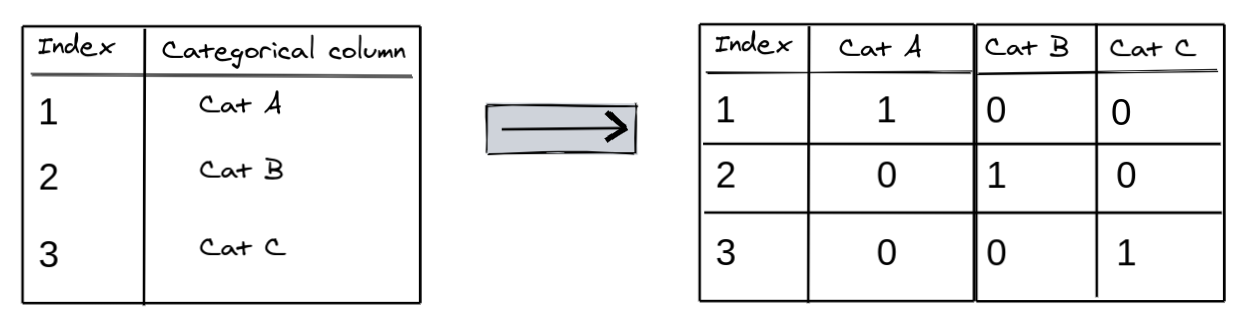

Let's one-hot encode categorical columns.

In [42]:
from sklearn.preprocessing import OneHotEncoder

In [44]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))


In [45]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

Finally, let's extract out all the numeric data for training

In [46]:
X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

As, we haven't created Validation set yet, so we'll use K fold cross validation

Gradient Boosting

We're now ready to train our gradient boosting machine (GBM) model. Here's how a GBM model works:

The average value of the target column and uses as an initial prediction every input.
The residuals (difference) of the predictions with the targets are computed.
A decision tree of limited depth is trained to predict just the residuals for each input.
Predictions from the decision tree are scaled using a parameter called the learning rate (this prevents overfitting)
Scaled predictions for the tree are added to the previous predictions to obtain the new and improved predictions.
Steps 2 to 5 are repeated to create new decision trees, each of which is trained to predict just the residuals from the previous prediction.
The term "gradient" refers to the fact that each decision tree is trained with the purpose of reducing the loss from the previous iteration (similar to gradient descent). The term "boosting" refers the general technique of training new models to improve the results of an existing model.

Here's a visual representation of gradient boosting:

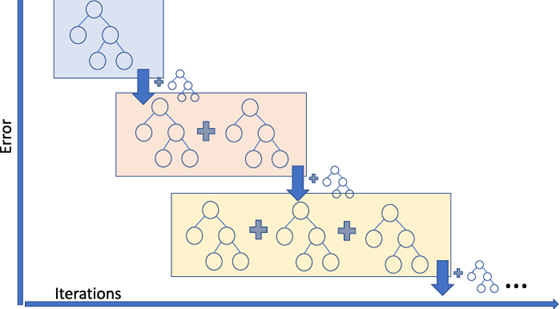

Training

To train a GBM, we can use the XGBRegressor class from the XGBoost library.



In [47]:
from xgboost import XGBRegressor

In [50]:

model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)

In [51]:
model.fit(X, targets)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

Prediction

We can now make predictions and evaluate the model using model.predict.

In [52]:
preds = model.predict(X)
preds

array([ 8073.2007,  7278.4395,  8812.854 , ...,  7913.415 ,  7336.718 ,
       10780.133 ], dtype=float32)

Evaluation

Let's evaluate the predictions using RMSE error.

In [73]:
from sklearn.metrics import root_mean_squared_error

In [75]:
def rmse(a, b):
    return root_mean_squared_error(a, b)

In [55]:
rmse(preds, targets)

c:\Users\Dell\Downloads\Data Science Stuff\Machine Learning\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


np.float64(2357.1278101525777)

Visualization

We can visualize individual trees using plot_tree (note: this requires the graphviz library to be installed).

In [56]:
import matplotlib.pyplot as plt
from xgboost import plot_tree
from matplotlib.pyplot import rcParams
%matplotlib inline 

In [57]:
rcParams['figure.figsize'] = 30,30

As i don't have currently GraphViz correctly installed so i'm just simply going to write code won't execute it and paste some images of what exactly code does

In [ ]:
plot_tree(model, rankdir='LR');

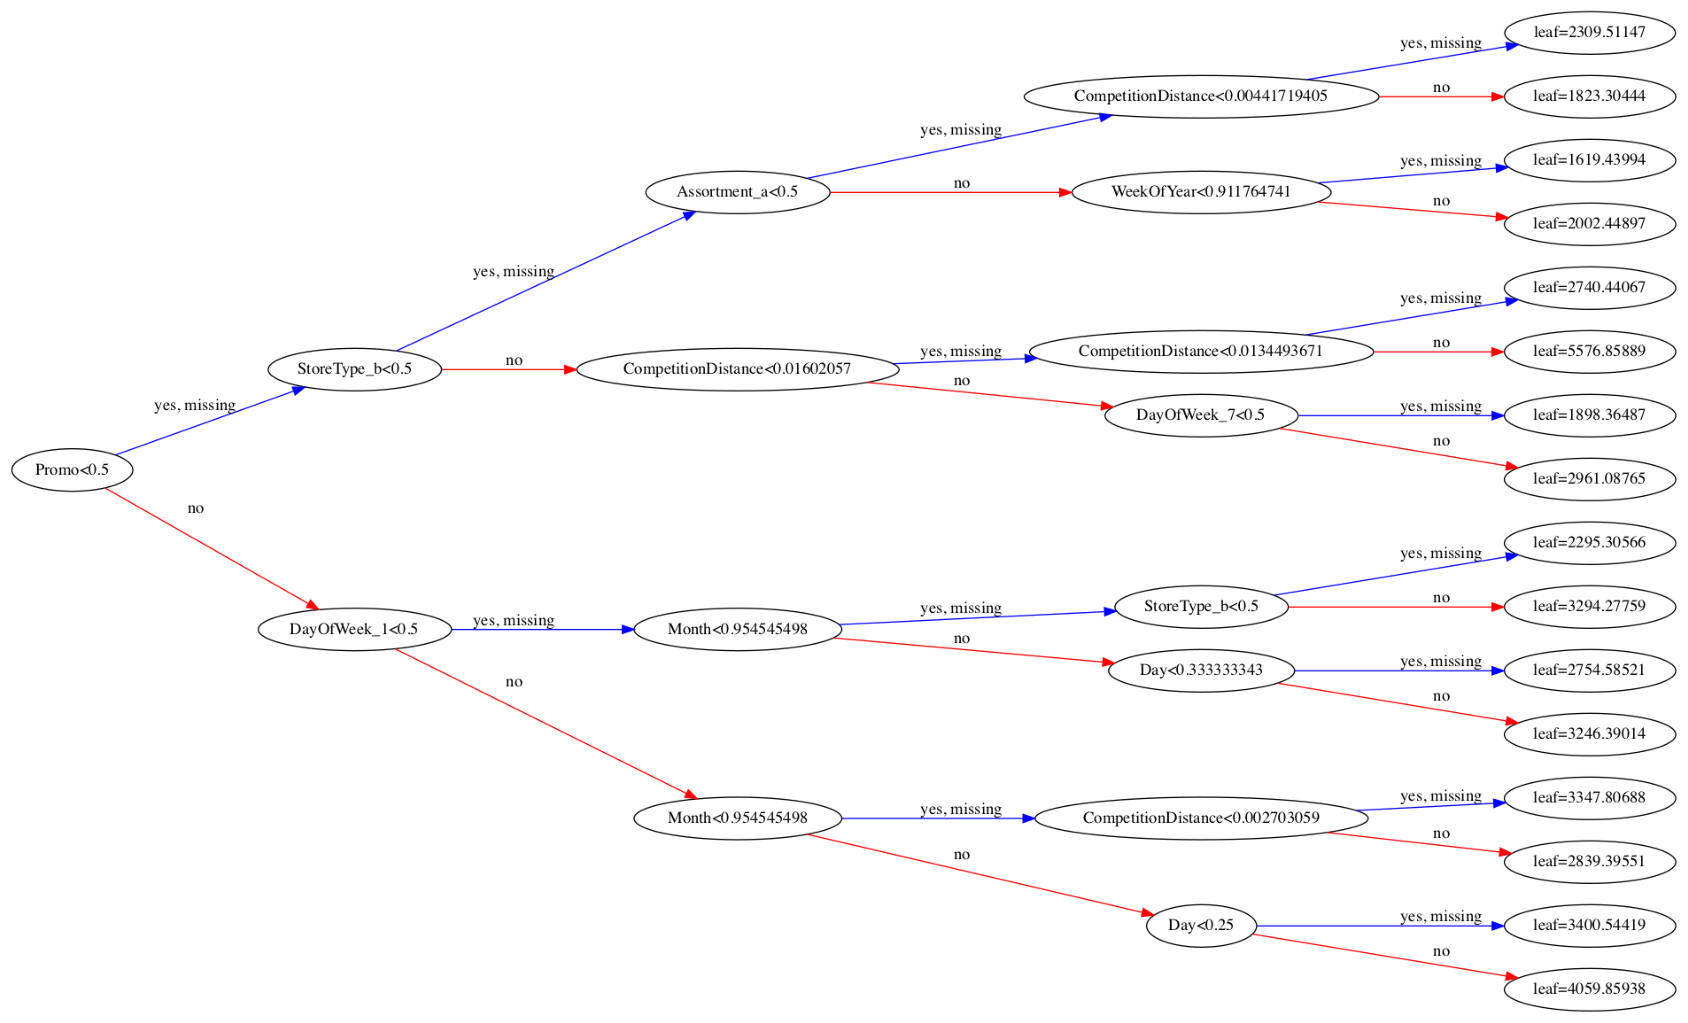

In [ ]:
plot_tree(model, rankdir='LR', num_trees=1);

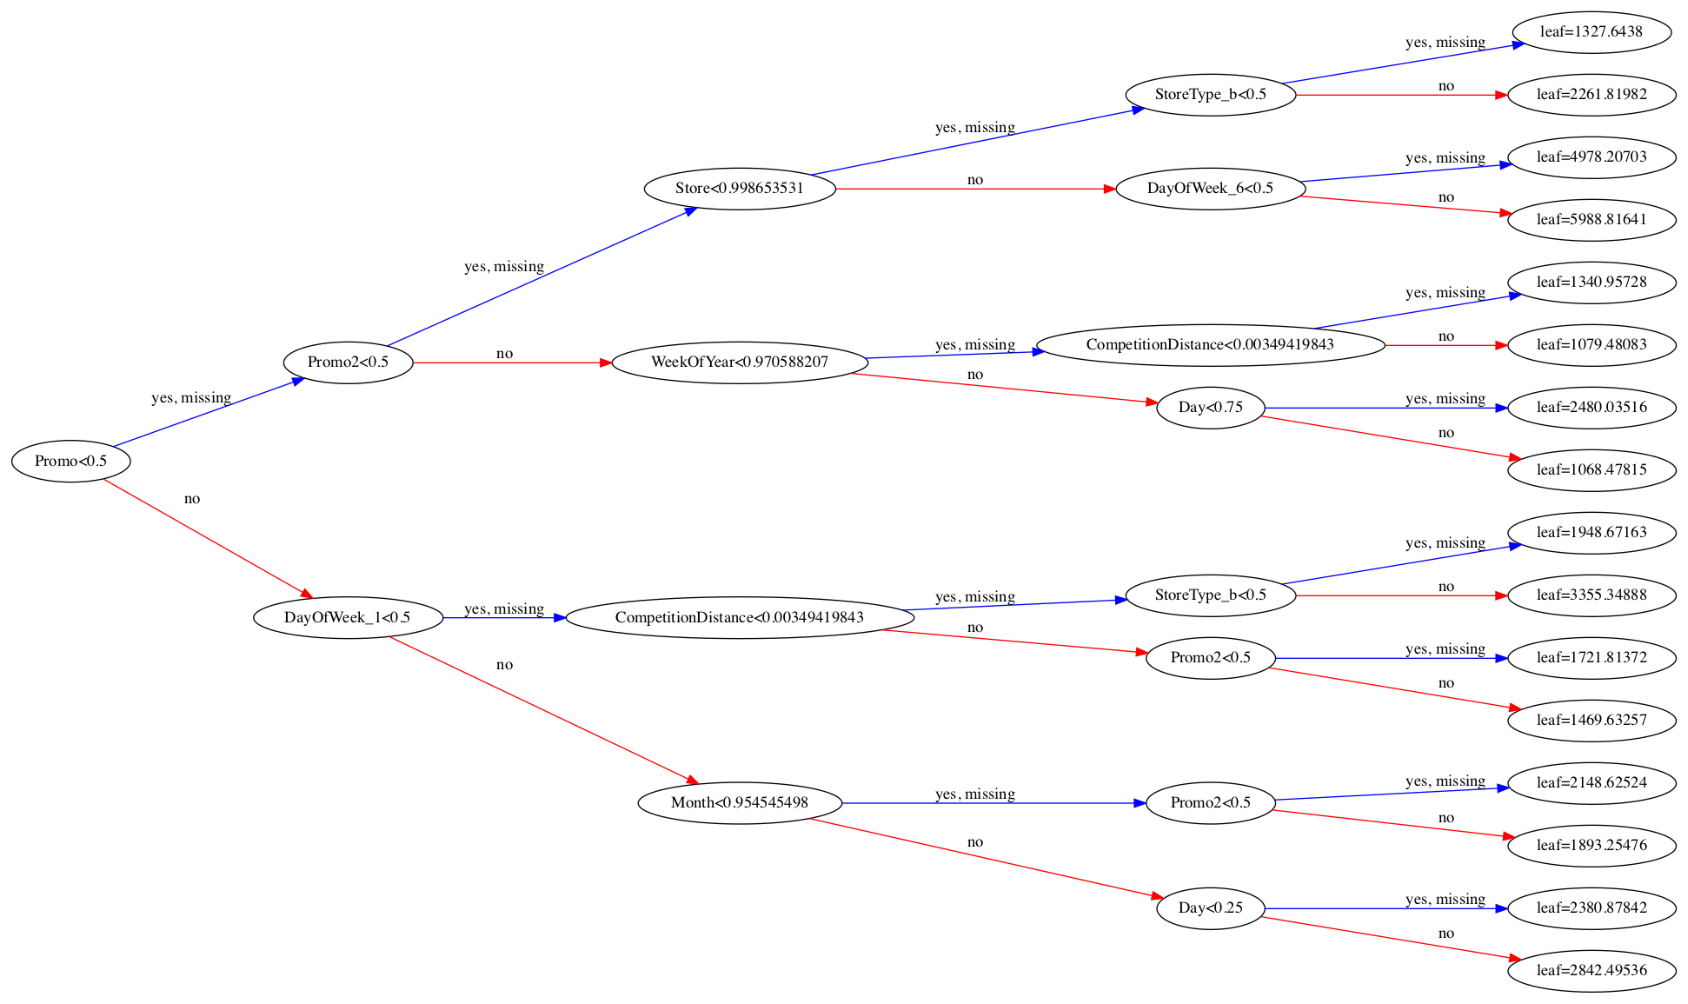

In [ ]:
plot_tree(model, rankdir='LR', num_trees=19);

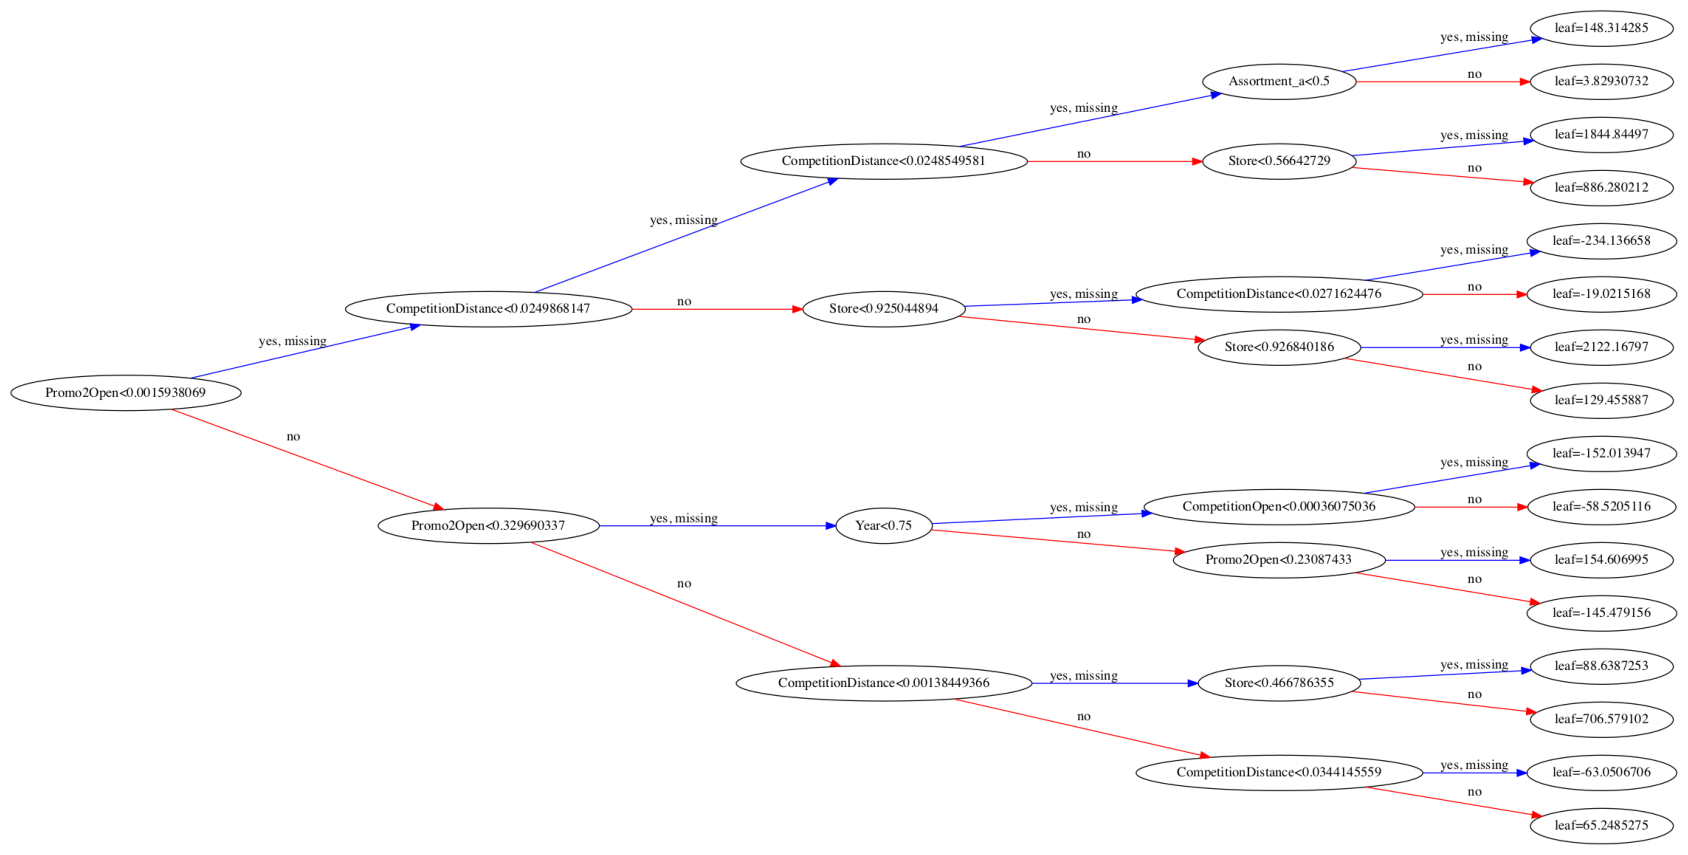

Notice how the trees only compute residuals, and not the actual target value. We can also visualize the tree as text.



In [59]:
trees = model.get_booster().get_dump()

In [60]:
len(trees)

20

In [61]:
print(trees[0])

0:[Promo<1] yes=1,no=2,missing=2
	1:[StoreType_b<1] yes=3,no=4,missing=4
		3:[Assortment_a<1] yes=7,no=8,missing=8
			7:[CompetitionDistance<0.0023071852] yes=15,no=16,missing=16
				15:leaf=181.975769
				16:leaf=-259.831238
			8:[WeekOfYear<0.921568632] yes=17,no=18,missing=18
				17:leaf=-467.055237
				18:leaf=-83.930191
		4:[CompetitionDistance<0.00791034941] yes=9,no=10,missing=10
			9:[CompetitionDistance<0.00593276182] yes=19,no=20,missing=20
				19:leaf=654.354065
				20:leaf=3492.14575
			10:[DayOfWeek_7<1] yes=21,no=22,missing=22
				21:leaf=-187.357132
				22:leaf=877.194702
	2:[DayOfWeek_1<1] yes=5,no=6,missing=6
		5:[Month<1] yes=11,no=12,missing=12
			11:[StoreType_b<1] yes=23,no=24,missing=24
				23:leaf=208.808884
				24:leaf=1208.23828
			12:[Day<0.200000003] yes=25,no=26,missing=26
				25:leaf=668.335449
				26:leaf=1160.14038
		6:[Month<1] yes=13,no=14,missing=14
			13:[CompetitionDistance<0.00138431112] yes=27,no=28,missing=28
				27:leaf=1261.60889
				28:leaf=752

Feature importance

Just like decision trees and random forests, XGBoost also provides a feature importance score for each column in the input.

In [65]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

<Axes: title={'center': 'Feature Importances'}, xlabel='importance', ylabel='feature'>

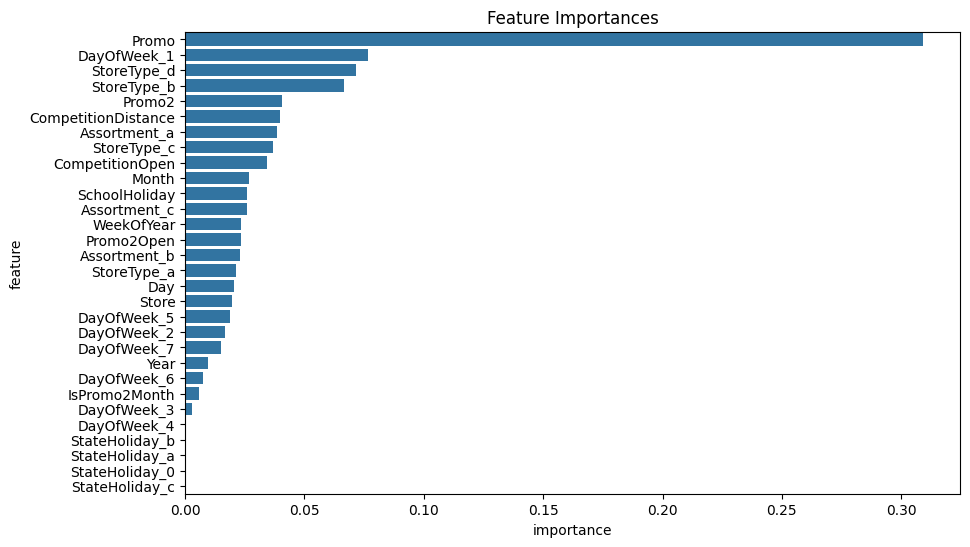

In [66]:
import seaborn as sns
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
sns.barplot(data=importance_df, x='importance', y='feature')


Based on this we can clearly see the promo has most importance 

K Fold Cross Validation

Notice that we didn't create a validation set before training our XGBoost model. We'll use a different validation strategy this time, called K-fold cross validation

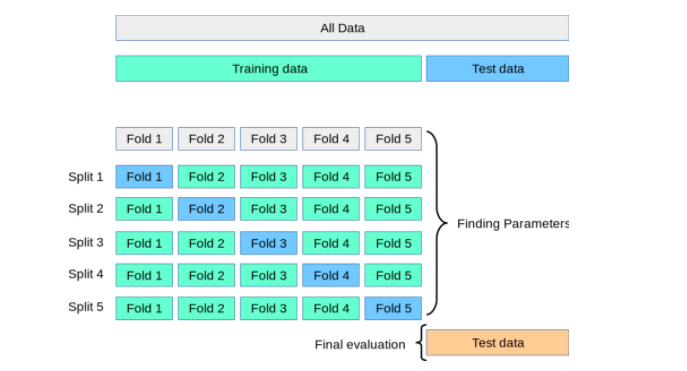

Scikit-learn provides utilities for performing K fold cross validation.

In [67]:
from sklearn.model_selection import KFold

Let's define a helper function train_and_evaluate which trains a model the given parameters and returns the trained model, training error and validation error.

In [68]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    return model, train_rmse, val_rmse

Now, we can use the KFold utility to create the different training/validations splits and train a separate model for each fold.



In [69]:
KFold = KFold(n_splits=5)

In [76]:
models = []

for train_idxs, val_idxs in KFold.split(X): 
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(X_train,train_targets,X_val,val_targets, max_depth=4, n_estimators=20)
    models.append(model)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

Train RMSE: 2370.7136430479463, Validation RMSE: 2448.739998478758
Train RMSE: 2376.830658491627, Validation RMSE: 2413.5622536102155
Train RMSE: 2386.944071778845, Validation RMSE: 2364.856120007352
Train RMSE: 2348.3401652445446, Validation RMSE: 2458.1552579968957
Train RMSE: 2370.9691440768092, Validation RMSE: 2441.7500928714353


Let's also define a function to average predictions from the 5 different models.

In [77]:
import numpy as np

def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [78]:
preds = predict_avg(models, X)
preds

array([8013.9463, 7508.8916, 8623.156 , ..., 7844.056 , 7589.815 ,
       9704.449 ], dtype=float32)

We can now use predict_avg to make predictions for the test set.

Hyperparameter Tuning and Regularization

Just like other machine learning models, there are several hyperparameters we can to adjust the capacity of model and reduce overfitting.

Here's a helper function to test hyperparameters with K-fold cross validation.

In [79]:
def test_params_kfold(n_splits, **params):
    train_rmses, val_rmses, models = [], [], []
    kfold = KFold(n_splits)
    for train_idxs, val_idxs in kfold.split(X):
        X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
        X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
        model, train_rmse, val_rmse = train_and_evaluate(X_train, train_targets, X_val, val_targets, **params)
        models.append(model)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
        print('Train RMSE: {}, Validation RMSE: {}'.format(np.mean(train_rmses), np.mean(val_rmses)))
        return models
    

Since it may take a long time to perform 5-fold cross validation for each set of parameters we wish to try, we'll just pick a random 10% sample of the dataset as the validation set.

In [80]:
from sklearn.model_selection import train_test_split

In [81]:
X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1)

In [82]:
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

n_estimators

The number of trees to be created. More trees = greater capacity of the model.

In [83]:
test_params(n_estimators = 250)

Train RMSE: 889.9948566546251, Validation RMSE: 910.0240977454839


max_depth

As you increase the max depth of each tree, the capacity of the tree increases and it can capture more information about the training set.

In [84]:
test_params(max_depth = 10)

Train RMSE: 675.2449070706444, Validation RMSE: 774.4468207621918
